In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm import tqdm_notebook as tqdm 
%matplotlib inline

In [2]:
def read_results(path = 'task1-bm25/'):
    
    to_read = [f for f in listdir(path) if isfile(join(path, f))]
    all_results = pd.DataFrame()
    
    for files in to_read:
        all_results = all_results.append(pd.read_csv(path + str(files),\
                              names = ['qid', 'Q0', 'result', 'rank', 'score', 'system'], sep = '\t'))
    return all_results
      
    
def get_mrr(all_results, query_feedback):
    
    

    mrr                      = []
    all_results['relevance'] = False

    
    for qid in query_feedback['qid'].unique():
        
        mrr_per_query            = []
        feedback_result          = list(query_feedback.loc[query_feedback['qid'] == qid]['result'])
       
        
        for result in feedback_result:
            
            result_index = all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result)].index.tolist()
            
            all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result), 'relevance'] = True 
            
            if len(result_index) > 0: 
                mrr_per_query.append(result_index[0] + 1)
                
        
        if len(mrr_per_query) != 0: mrr.append(1/min(mrr_per_query))
        else: mrr.append(0)
         
    return np.mean(mrr), all_results

In [165]:
def calc_recall(all_results, query_feedback):
    
    recall = []
    precision = []
    remove_list = set()
    
    for qid in tqdm(range(1,65)):
        
        all_results.loc[(all_results['qid'] == qid), 'relevant_len'] \
                            = len(query_feedback.loc[(query_feedback['qid'] == qid)])
            
        recall_numerator = 0
        
        for index,row in all_results.loc[all_results['qid'] == qid].iterrows():
            
            if qid in list(query_feedback['qid']):
            
                if(row['relevance']): 

                    recall_numerator += 1
                    recall.append(recall_numerator/(row['relevant_len']))
                    precision.append(recall_numerator/row['rank'])


                else: 
                    recall.append(recall_numerator/row['relevant_len'])
                    precision.append(recall_numerator/row['rank'])
            
            else:
                #all_results = all_results.drop(qid, axis = 0)
                recall.append(0)
                precision.append(0)
                remove_list.add(qid)
    
    all_results['recall'] = recall
    all_results['precision'] = precision
    all_results = all_results[~all_results['qid'].isin(remove_list)]
    
    return all_results, recall, precision, remove_list

In [166]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results()

mrr, all_results = get_mrr(all_results, query_feedback)
all_results, recall, precision, remove_list  = calc_recall(all_results, query_feedback)

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))

In [167]:
np.mean(all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').sum() /\
            all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').count())

precision    0.18006
dtype: float64

In [168]:
recall_precision = all_results.loc[all_results['rank'] == 5][['qid','precision']].set_index('qid')

In [169]:
recall_precision['precision@20'] = all_results.loc[all_results['rank'] == 20][['qid','precision']].set_index('qid')

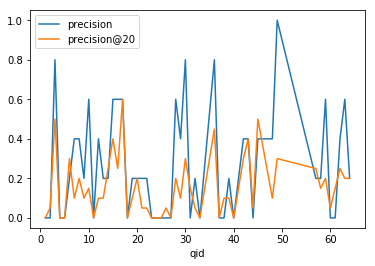

In [170]:
recall_precision.sort_index().plot()

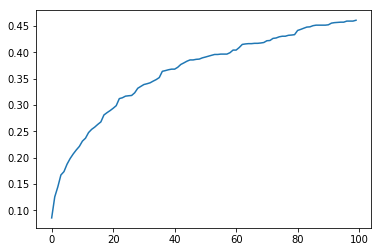

In [171]:
recall_plot_df = pd.DataFrame()

for qid in all_results['qid'].unique():
    
    recall_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'recall']
    
recall_plot_df['mean'] = recall_plot_df.mean(axis = 1)
recall_plot_df['mean'].plot()

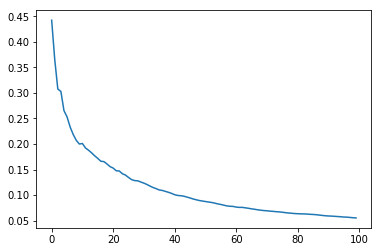

In [173]:
precision_plot_df = pd.DataFrame()

for qid in all_results['qid'].unique():
    
    precision_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'precision']
    
precision_plot_df['mean'] = precision_plot_df.mean(axis = 1)
precision_plot_df['mean'].plot()